In [1]:
### distance dependent state transition demo
    
#     In this model the transition probability depends on the distance
#     between the latent locations associated with each discrete state.
#     Specifically, each state k has a location, \ell_k \in R^J, and 
#     the probability of transitioning is 
#         Pr(z_t = k | z_{t-1} = k') 
#              \propto exp(-||\ell_k - \ell_{k'}||/L)   if k \neq k'
#              \propto p_kk                             if k = k'
#     where L is a length scale that we treat as a hyperparameter. 
#     
#     Here the observations are marked point processes.

In [2]:
import os
os.chdir("/Users/scott/Projects/ssm-xinyi")

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes, norm
#matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.models import HMM
from ssm.util import find_permutation

#### clusterless HMM
#### input data format: tensor T by D0 by 1+D1
#### spikes = datas[:, :, 0]
#### marks = datas[:, :, 1:]

### e.g. parameters
npr.seed(1)

In [3]:
#### Generate an HMM
# Set the parameters of the HMM

T = 2000    # number of time bins
K = 6        # number of discrete states, e.g. location

### Poisson
D0 = 10  # number of tetrodes
D1 = 50 # max number of events (Poisson)
D2 = 3 # spike count dimension (per event 0 or 1) + two mark dimensions
D = (D0, D1, D2) # tuple

# Make an HMM
true_hmm = HMM(K, D, transitions='distance', observations="clusterless")

# Sample some data from the HMM
z, y = true_hmm.sample(T)

# likelihood
true_ll = true_hmm.log_probability(y)

spikes = np.sum(y[:, :, :, 0], axis=2) # T by D0
marks = y[:, :, :, 1:] # T by D0 by D2 by D3

### true parameters ############
L = true_hmm.transitions.L  # length scale/smoothing
ell = true_hmm.transitions.ell # latent 2D space
log_p = true_hmm.params[1][1]

prr = np.exp(log_p) # diagonal prob
Ps_dist = np.sqrt(np.sum((ell[:, :, None] - ell[:, :, None].T) ** 2, axis = 1))
log_P = -Ps_dist / L
log_P += np.diag(log_p)
Ps = np.exp(log_P)
Ps /= Ps.sum(axis=1, keepdims=True)

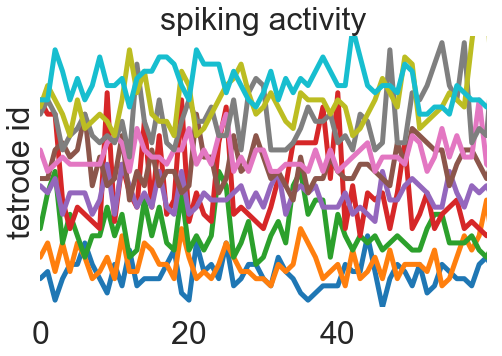

In [4]:
### plot simulated data

##### ground spike trains
plt.figure(figsize=(8, 5)) # width, height
plt.plot(spikes + 3 * np.arange(D0),  '-', linewidth=5)
plt.xlim(0, 60)
plt.ylim(0, 3*D0+8)
plt.title("spiking activity", fontsize=32)
plt.ylabel('tetrode id', fontsize=32)
plt.xticks(np.arange(0, 60, step=20), fontsize=32)
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

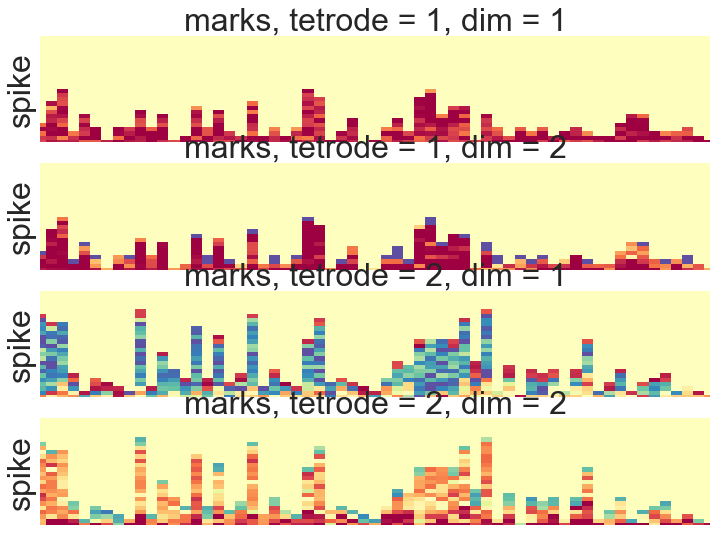

In [5]:
##### marked point processes
plt.figure(figsize=(12, 9)) # width, height
plt.subplot(411)
plt.imshow(np.transpose(marks[:, 2, :, 0]), cmap="Spectral", vmin=-1.5, vmax=1.5, aspect="auto")
plt.xlim(0, 60)
plt.ylim(0, D1/2)
plt.title("marks, tetrode = 1, dim = 1", fontsize=32)
plt.yticks([])
plt.xticks([])
plt.ylabel("spike", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(412)
plt.imshow(np.transpose(marks[:, 2, :, 1]), cmap="Spectral", vmin=-1.5, vmax=1.5, aspect="auto")
plt.xlim(0, 60)
plt.ylim(0, D1/2)
plt.title("marks, tetrode = 1, dim = 2", fontsize=32)
plt.yticks([]);
plt.xticks([]);
plt.ylabel("spike", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(413)
plt.imshow(np.transpose(marks[:, 3, :, 0]), cmap="Spectral", vmin=-1.5, vmax=1.5, aspect="auto")
plt.xlim(0, 60)
plt.ylim(0, D1/2)
plt.title("marks, tetrode = 2, dim = 1", fontsize=32)
plt.yticks([]);
plt.xticks([]);
plt.ylabel("spike", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(414)
plt.imshow(np.transpose(marks[:, 3, :, 1]), cmap="Spectral", vmin=-1.5, vmax=1.5, aspect="auto")
plt.xlim(0, 60)
plt.ylim(0, D1/2)
plt.title("marks, tetrode = 2, dim = 2", fontsize=32)
plt.yticks([]);
plt.xticks([]);
plt.ylabel("spike", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

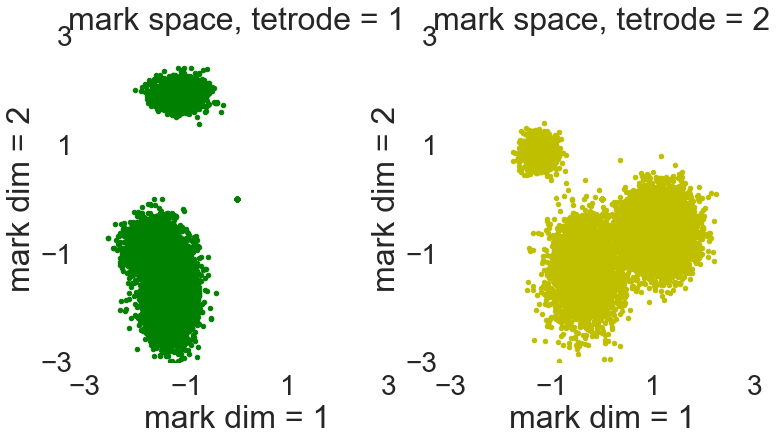

In [6]:
###### mark space
plt.figure(figsize=(8*1.5, 6))

plt.subplot(121)
a1 = marks[:, 2, :, 0]
a2 = marks[:, 2, :, 1]
b1 = np.reshape(a1, (np.product(a1.shape),))
b2 = np.reshape(a2, (np.product(a1.shape),))
plt.plot(b1,b2,'.g')
plt.title("mark space, tetrode = 1", fontsize=32)
plt.xlabel('mark dim = 1', fontsize=32)
plt.ylabel('mark dim = 2', fontsize=32)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xticks(np.arange(-3, 3.01, step=2), fontsize=28)
plt.yticks(np.arange(-3, 3.01, step=2), fontsize=28)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(122)
a1 = marks[:, 3, :, 0]
a2 = marks[:, 3, :, 1]
b1 = np.reshape(a1, (np.product(a1.shape),))
b2 = np.reshape(a2, (np.product(a1.shape),))
plt.plot(b1,b2,'.y')
plt.title("mark space, tetrode = 2", fontsize=32)
plt.xlabel('mark dim = 1', fontsize=32)
plt.ylabel('mark dim = 2', fontsize=32)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xticks(np.arange(-3, 3.01, step=2), fontsize=28)
plt.yticks(np.arange(-3, 3.01, step=2), fontsize=28)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()

In [7]:
### ############################################### ###
###        Fit an HMM to this synthetic data        ###
### ############################################### ###
N_iters = 30
hmm = HMM(K, D, transitions="distance", observations="clusterless")
hmm_lls = hmm.fit(y, method="em", num_em_iters=N_iters)
#hmm_lls = hmm.fit(y)


# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(y)))
hmm_z = hmm.most_likely_states(y)

LP: -121664.6: 100%|██████████| 30/30 [01:33<00:00,  3.00s/it]


In [8]:
##### ####################
### parameter estimates #################
L_hmm = hmm.transitions.L  # length scale/smoothing
ell_hmm = hmm.transitions.ell # latent 2D space
log_p_hmm = hmm.params[1][1]


prr_hmm = np.exp(log_p_hmm) # diagonal prob
Ps_dist_hmm = np.sum((ell_hmm[:, :, None] - ell_hmm[:, :, None].T) ** 2, axis = 1)
log_P_hmm = -Ps_dist_hmm / L_hmm
log_P_hmm += np.diag(log_p_hmm)
Ps_hmm = np.exp(log_P_hmm)
Ps_hmm /= Ps_hmm.sum(axis=1, keepdims=True)


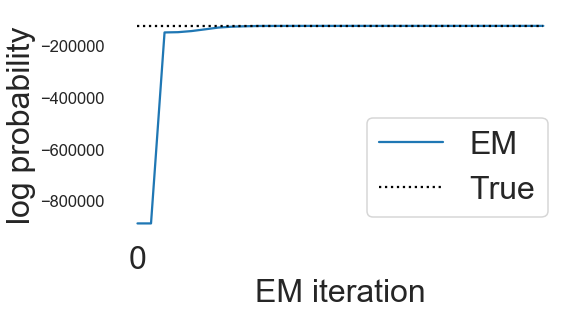

In [9]:
##### ####################
##### plot fitted results

######### LogL
plt.figure(figsize=(8, 4))
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xticks(np.arange(0, N_iters, step=40), fontsize=32)
plt.xlabel("EM iteration", fontsize=32)
plt.ylabel("log probability", fontsize=32)
plt.legend(loc="lower right", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False) 
plt.show()

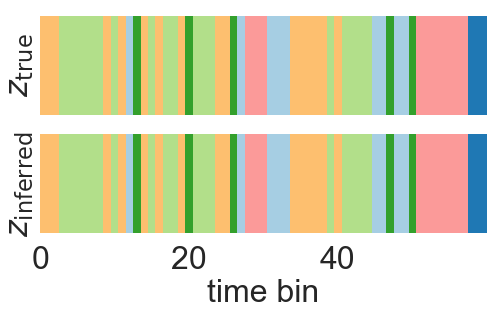

In [10]:
######## Zs
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], cmap='Paired', vmin=0, vmax=D0, aspect="auto")
plt.xlim(0, 60)
plt.ylabel("$z_{\\mathrm{true}}$", fontsize=32)
plt.yticks([])
plt.xticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(212)
plt.imshow(hmm_z[None,:], cmap='Paired', vmin=0, vmax=D0, aspect="auto")
plt.xlim(0, 60)
plt.ylabel("$z_{\\mathrm{inferred}}$", fontsize=32)
plt.yticks([])
plt.xticks(np.arange(0, 60, step=20), fontsize=32)
plt.xlabel("time bin", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

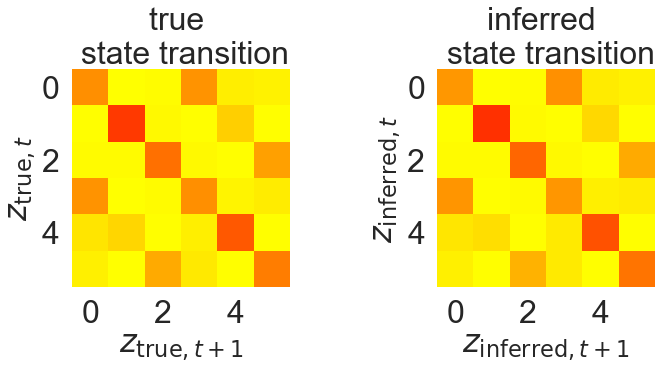

In [11]:
###### Ps
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(true_hmm.transitions.transition_matrix, cmap="autumn_r", vmin=0, vmax=1, aspect="equal")
plt.xlim(-.5,K-.5)
plt.ylim(K-.5,-.5)
plt.yticks(np.arange(0, K, step=2), fontsize=32)
plt.xticks(np.arange(0, K, step=2), fontsize=32)
plt.title("true \n state transition", fontsize=32)
plt.xlabel("$z_{\\mathrm{true},t+1}$", fontsize=32)
plt.ylabel("$z_{\\mathrm{true},t}$", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(122)
plt.imshow(hmm.transitions.transition_matrix, cmap="autumn_r", vmin=0, vmax=1, aspect="equal")
plt.xlim(-.5,K-.5)
plt.ylim(K-.5,-.5)
plt.yticks(np.arange(0, K, step=2), fontsize=32)
plt.xticks(np.arange(0, K, step=2), fontsize=32)
plt.title("inferred \n state transition", fontsize=32)
plt.xlabel("$z_{\\mathrm{inferred},t+1}$", fontsize=32)
plt.ylabel("$z_{\\mathrm{inferred},t}$", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplots_adjust(top=0.88) 
plt.show()

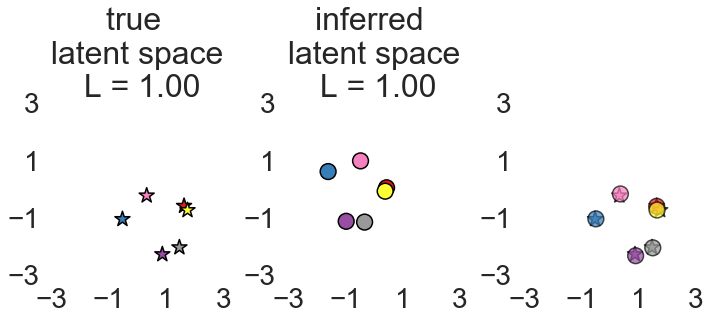

In [12]:
##### ell
### orthogonal transformation
def orthogonal_transformation(A, B):
    # A: input matrix
    # B: target matrix
    A_mu = A - A.mean(axis=0)
    B_mu = B - B.mean(axis=0)
    R, s = orthogonal_procrustes(A_mu, B_mu)
    scale = s / np.square(norm(A_mu))
    A2 = scale * np.dot(A_mu, R) + B.mean(axis=0)
    
    return A2

ell_hmm_ot = orthogonal_transformation(ell_hmm, ell)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.scatter(ell[:,0], ell[:,1], 
            c=range(K), cmap="Set1", marker="*", s=250, edgecolors='k', alpha=1)
plt.title("true \n latent space \n L = %.2f" % L, fontsize=32)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xticks(np.arange(-3, 3.01, step=2), fontsize=28)
plt.yticks(np.arange(-3, 3.01, step=2), fontsize=28)
plt.gca().set_aspect('equal', adjustable='box')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(132)
plt.scatter(ell_hmm[:,0], ell_hmm[:,1], 
            c=range(K), cmap="Set1", marker="o", s=250, edgecolors='k', alpha=1)
plt.title("inferred \n latent space \n L = %.2f" % L_hmm, fontsize=32)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xticks(np.arange(-3, 3.01, step=2), fontsize=28)
plt.yticks(np.arange(-3, 3.01, step=2), fontsize=28)
plt.gca().set_aspect('equal', adjustable='box')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(133)
plt.scatter(ell[:,0], ell[:,1], 
            c=range(K), cmap="Set1", marker="*", s=250, edgecolors='k', alpha=.8)
plt.scatter(ell_hmm_ot[:,0], ell_hmm_ot[:,1], 
            c=range(K), cmap="Set1", marker="o", s=250, edgecolors='k', alpha=.7)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xticks(np.arange(-3, 3.01, step=2), fontsize=28)
plt.yticks(np.arange(-3, 3.01, step=2), fontsize=28)
plt.gca().set_aspect('equal', adjustable='box')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplots_adjust(top=0.92) 
plt.show()